## Viewing a DICOM series via DRS

In [21]:
import pydicom as dicom
import matplotlib.pylab as plt

### Find images in a series via Data Connect
This queries the IDC BigQuery tables

In [22]:
from ipywidgets import IntProgress
from IPython.display import display
max_count = 30

Query the IDC via Data Connect

In [27]:
from fasp.search import DataConnectClient
dcClient = DataConnectClient('http://localhost:8089',  
                         debug=False, passport="~/Downloads/task-specific-token-20.txt")

progress_bar = IntProgress(min=0, max=max_count) # instantiate the bar
display(progress_bar) # display the bar

series_id = '1.3.6.1.4.1.14519.5.2.1.9203.4004.180247944276769278137408963507'

images = dcClient.run_query(f'''SELECT  crdc_instance_uuid, SliceLocation
 FROM bigquery_public.idc_v11.dicom_all 
where SeriesInstanceUID = 
'{series_id}' '''
                  ,progessIndicator=progress_bar
                  ,return_type='json')

IntProgress(value=0, max=30)

Sort images on slice location

In [28]:
len(images)

64

In [29]:
import pandas as pd
pd.DataFrame(images)

,crdc_instance_uuid,SliceLocation
0,f4e077ff-c363-49a5-a820-817e1d4bf3fa,5.000
1,87bb22b3-293c-4c52-a67b-aa54f3876883,-20.000
2,50c51808-a301-4e65-adf0-1cb93ed19da6,-135.000
3,4b027231-1ed3-4d57-a47e-a16dc4466cf6,-265.000
4,726f9bac-2c48-44e0-af66-386c71138f5b,-225.000
...,...,...
59,097c5556-7cac-47f4-a85c-dfae88d8fb68,-280.000
60,d264332c-df18-4421-a22f-b52d0da26fd1,-70.000
61,464b45e0-1f72-4411-9eda-4efc0e5a06d2,-170.000
62,ea517fdf-de02-4376-9ada-1ad0f5068c8f,-60.000


In [31]:
def getlocation(im):
  return float(im['SliceLocation'])

images.sort(key=getlocation)

In [32]:
from fasp.loc import crdcDRSClient
drs_cl = crdcDRSClient("~/.keys/crdc_credentials.json","gs")

Define a function to retrieve the DRS image and return it as pydicom. A temporary copy of the file is made locally so it can be passed to the dicom python package.

In [33]:
import tempfile
import requests

def getImage(image):
    url = drs_cl.get_access_url(image['crdc_instance_uuid'])
    with tempfile.NamedTemporaryFile(mode='wb') as file:
        
        response = requests.get(url)
        file.write(response.content)
        file.seek(0)
        ds = dicom.dcmread(file.name)
        return ds

### Test this out with a single image

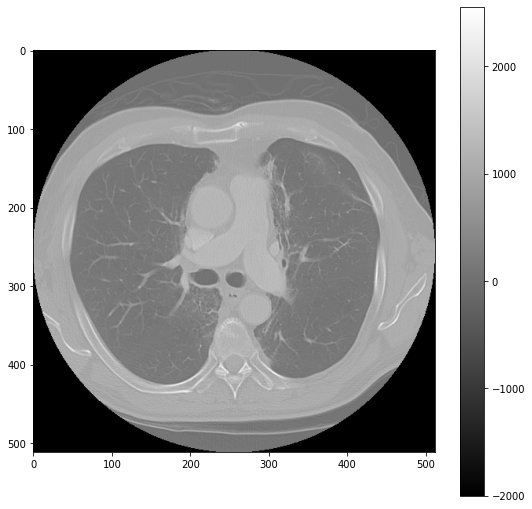

In [34]:
dsv = getImage(images[40])
plt.imshow(dsv.pixel_array,  cmap=plt.cm.gray)
plt.colorbar()

### Make it interactive
Use the widgets to select a specific image from the series

When you make a selection to display the image the following occurs
* The notebook calls the CRDC DRS service to get a URL for the file
* The DRS server checks your credentials and, if permitted, provides the URL
* The notebook sends a request to Google Cloud Storage for the file
* Google Cloud Storage verfies the credentials provided and, if permitted, provides the file
* The notebook converts the image to a file for display

In [35]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import Image, display
from io import BytesIO



In [36]:
%%time
features = {'Free scroll':2,'Start':20, 'Center':30, 'Top':10, 'Abdomen':5, 'trachea bifurcation':42}

#plt.rcParams["figure.autolayout"] = True 
@interact
def show_viewer(slice=widgets.BoundedIntText(min=0, max=len(images)-1, step=1, value=features['Start']), 
                feature = features.keys(), subs=widgets.Checkbox(value=False)):
    
    if feature != 'Free scroll':
        slice = features[feature]
    #selected = 
    #else:
    #    selected = images[slice]
    image =  getImage(images[slice])
    plt.rcParams["figure.figsize"] = [9.00, 9.00]
    plt.imshow(image.pixel_array,  cmap=plt.cm.gray)
    
    
    if subs:
        plt.rcParams["figure.figsize"] = [7.50, 7.50]
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        prev_image =  getImage(images[slice-1])
        imgplot = plt.imshow(prev_image.pixel_array,  cmap=plt.cm.gray)
        #ax.set_title(f'Slice {slice-1}')
        ax.set_title(f'Below')
        ax = fig.add_subplot(1, 2, 2)
        next_image =  getImage(images[slice+1])
        imgplot = plt.imshow(next_image.pixel_array,  cmap=plt.cm.gray)
        #ax.set_title(f'Slice {slice+1}')
        ax.set_title(f'Above')

    print (f'Slice number: {slice}')
    print (f'Slice Location: {image.SliceLocation}')    

interactive(children=(BoundedIntText(value=20, description='slice', max=63), Dropdown(description='feature', o…

CPU times: user 460 ms, sys: 91.7 ms, total: 551 ms
Wall time: 1.35 s


In [29]:
def download_image(image):
    drs_obj = drs_cl.get_object(image['crdc_instance_uuid'])
    #print(drs_obj)
    url = drs_cl.get_access_url(image['crdc_instance_uuid'])
    name = drs_obj['access_methods'][0]['access_url']['url'].split('/')[-1]
    with open(f'images/{name}','wb') as file:
        response = requests.get(url)
        file.write(response.content)

In [30]:
for i in images:
    download_image(i)

{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/c7df379a-8538-4a8f-9c22-e123596a3c4f.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': '43ceecee030dead69459f2383cb4fc3f', 'type': 'md5'}], 'created_time': '2020-09-18T18:03:07.584719', 'description': None, 'form': 'object', 'id': 'dg.4DFC/c7df379a-8538-4a8f-9c22-e123596a3c4f', 'mime_type': 'application/json', 'name': '', 'self_uri': 'drs://dg.4DFC:c7df379a-8538-4a8f-9c22-e123596a3c4f', 'size': 528592, 'updated_time': '2022-03-26T13:55:16.476375', 'version': '2f568c5f'}
{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/11c72c4d-e8ba-4982-8a11-ed903700e74d.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': '37674972602c16a95c54260f4caad9b4', 'type': 'md5'}], 'created_time': '2020-09-19T03:45:53.379194', 'description': None, 'form': 'object', 'id': 'dg.4DFC/11c72c4d-e8ba-4982-8a11-ed903700e74d', 'mime_type':

{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/8a6880b2-108d-477c-85f0-bc3b798ee0ab.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': '0432c4e2dfc6020831d929347461f8d9', 'type': 'md5'}], 'created_time': '2020-09-19T02:44:40.238677', 'description': None, 'form': 'object', 'id': 'dg.4DFC/8a6880b2-108d-477c-85f0-bc3b798ee0ab', 'mime_type': 'application/json', 'name': '', 'self_uri': 'drs://dg.4DFC:8a6880b2-108d-477c-85f0-bc3b798ee0ab', 'size': 528592, 'updated_time': '2022-03-29T16:01:29.994632', 'version': '54680e6d'}
{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/8d628b54-e3e4-43c3-8d08-cf7701a3ca57.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': 'ac9696e160c06a6347fc9bd306ce1321', 'type': 'md5'}], 'created_time': '2020-09-18T13:33:50.146766', 'description': None, 'form': 'object', 'id': 'dg.4DFC/8d628b54-e3e4-43c3-8d08-cf7701a3ca57', 'mime_type':

{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/464b45e0-1f72-4411-9eda-4efc0e5a06d2.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': 'ff430b9ded87b72d2b063c4b219051ec', 'type': 'md5'}], 'created_time': '2020-09-19T07:48:12.510815', 'description': None, 'form': 'object', 'id': 'dg.4DFC/464b45e0-1f72-4411-9eda-4efc0e5a06d2', 'mime_type': 'application/json', 'name': '', 'self_uri': 'drs://dg.4DFC:464b45e0-1f72-4411-9eda-4efc0e5a06d2', 'size': 528592, 'updated_time': '2022-03-28T20:42:11.752262', 'version': 'efe022db'}
{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/be800702-8cf3-4da6-8410-3b7ac4ffdb9b.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': '5f09712358aaefdd53e22c1248bbadd6', 'type': 'md5'}], 'created_time': '2020-09-19T23:47:18.514546', 'description': None, 'form': 'object', 'id': 'dg.4DFC/be800702-8cf3-4da6-8410-3b7ac4ffdb9b', 'mime_type':

{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/8b6c89e2-f11a-426a-a00c-e62fa1958827.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': '8694038f3aef16eec645440370d8bb02', 'type': 'md5'}], 'created_time': '2020-09-18T19:25:18.730087', 'description': None, 'form': 'object', 'id': 'dg.4DFC/8b6c89e2-f11a-426a-a00c-e62fa1958827', 'mime_type': 'application/json', 'name': '', 'self_uri': 'drs://dg.4DFC:8b6c89e2-f11a-426a-a00c-e62fa1958827', 'size': 528592, 'updated_time': '2022-03-10T12:32:20.772169', 'version': 'b11b4959'}
{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/3cf9bb26-0df4-4733-9e8e-3d7f432c58e8.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': 'f20f5d471ae1b155a92a9091b84855e2', 'type': 'md5'}], 'created_time': '2020-09-18T20:25:46.286698', 'description': None, 'form': 'object', 'id': 'dg.4DFC/3cf9bb26-0df4-4733-9e8e-3d7f432c58e8', 'mime_type':

{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/d01a5160-2dfd-4e01-9c1d-7f5dbe4841d6.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': '92d36df52ae692b52ecb6e059acaa6ab', 'type': 'md5'}], 'created_time': '2020-09-19T08:20:44.868259', 'description': None, 'form': 'object', 'id': 'dg.4DFC/d01a5160-2dfd-4e01-9c1d-7f5dbe4841d6', 'mime_type': 'application/json', 'name': '', 'self_uri': 'drs://dg.4DFC:d01a5160-2dfd-4e01-9c1d-7f5dbe4841d6', 'size': 528592, 'updated_time': '2022-03-22T15:40:27.459201', 'version': '45d33951'}
{'access_methods': [{'access_id': 'gs', 'access_url': {'url': 'gs://public-datasets-idc/2535fcb5-b8fa-4c34-b264-b3d3de584b69.dcm'}, 'region': '', 'type': 'gs'}], 'aliases': [], 'checksums': [{'checksum': '117fc142ed09de7ffa38030beeafd310', 'type': 'md5'}], 'created_time': '2020-09-20T03:52:36.460761', 'description': None, 'form': 'object', 'id': 'dg.4DFC/2535fcb5-b8fa-4c34-b264-b3d3de584b69', 'mime_type':